In [1]:
import os
import numpy as np
import pandas as pd
from geolife_parser import *
from geolife_data import upsample_df

# %matplotlib inline
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

In [ ]:
SHOW_PLOTS = TRUE

In [2]:
import pandas as pd
if os.path.exists("geolife.pkl"):
    data = pd.read_pickle('geolife.pkl')  # reads 'geolife.pkl' into df
else:
    data = read_all_users("./Data")
    data.to_pickle('geolife.pkl')

In [3]:
data.head()

,time,lat,lon,alt,trip_id,transport_mode,user_id
0,2009-01-03 01:21:34,39.974294,116.399741,492.0,13520090103012134,NaN,135
1,2009-01-03 01:21:35,39.974292,116.399592,492.0,13520090103012134,NaN,135
2,2009-01-03 01:21:36,39.974309,116.399523,492.0,13520090103012134,NaN,135
3,2009-01-03 01:21:38,39.974320,116.399588,492.0,13520090103012134,NaN,135
4,2009-01-03 01:21:39,39.974365,116.399730,491.0,13520090103012134,NaN,135


There are several trips in which users have used multiple transport modes. To identify them uniquely let's augment trip_ids with transport_mode.

In [4]:
data["trip_id"] = data["trip_id"] + "#" +  data["transport_mode"].astype(str)

In [5]:
data.head()

,time,lat,lon,alt,trip_id,transport_mode,user_id
0,2009-01-03 01:21:34,39.974294,116.399741,492.0,13520090103012134#nan,NaN,135
1,2009-01-03 01:21:35,39.974292,116.399592,492.0,13520090103012134#nan,NaN,135
2,2009-01-03 01:21:36,39.974309,116.399523,492.0,13520090103012134#nan,NaN,135
3,2009-01-03 01:21:38,39.974320,116.399588,492.0,13520090103012134#nan,NaN,135
4,2009-01-03 01:21:39,39.974365,116.399730,491.0,13520090103012134#nan,NaN,135


In [7]:
print("Transport modes: ", list(map(lambda x: get_transport_label(x), sorted(data.transport_mode.dropna().unique().astype(np.int)))))

Transport modes:  ['taxi', 'walk', 'bike', 'bus', 'car', 'subway', 'train', 'airplane', 'boat', 'run', 'motorcycle', 'taxi']


We're looking for trajectories with interesting behaviors, so that we can learn those behaviors. Now the question is, what is interesting? 

Let's consider a 2d state space. Are straight lines interesting? Of course, no. Straight lines don't tell us anything new that we don't already know. Any trivial reward function can explain such trajectories e.g., $R(s) = 0, \forall s \in S$. For all trajectories that can be explained without knowing the reward function, in other words, those that can be explained assuming a constant reward function over the state space, we don't need Markov Decision Processes. It's because there's no utility to be maximized, they are simply processes which under the Markov assumption can also be studied without any animal interaction.

To illustrate, consider a sink in some gravitational environment, the water is going to go down in it. There's a lot of value in modeling that, but in the contex of IRL we want to learn from expert demonstrations, so modeling human behavior is very useful. We don't want to model inanimate things, we want to model intelligent animal behavior and learn from it.

To do this, we're going to have to filter interesting trajectories first. To keep filtering simple, let's only consider trajectories with transport mode specified, and let's further limit ourself to only "car" trajectories.

In [8]:
data = data[~pd.isna(data.transport_mode)]
data.transport_mode = data.transport_mode.astype(np.int).values

In [9]:
# let's use string representation for transport mode
data.loc[:, "transport_mode"] = data["transport_mode"].apply(lambda x: get_transport_label(x)).values

In [10]:
data.head()

,time,lat,lon,alt,trip_id,transport_mode,user_id
0,2008-08-16 07:47:56,39.930748,116.306143,0.0,10420080816074756#0.0,taxi,104
1,2008-08-16 07:47:57,39.930792,116.306167,0.0,10420080816074756#0.0,taxi,104
2,2008-08-16 07:48:00,39.931093,116.306342,0.0,10420080816074756#0.0,taxi,104
3,2008-08-16 07:48:05,39.930950,116.306313,0.0,10420080816074756#0.0,taxi,104
4,2008-08-16 07:48:10,39.930963,116.306383,0.0,10420080816074756#0.0,taxi,104


In [11]:
def plot_trips_by_user(data):
    trips_by_user = data.groupby(["user_id"])["trip_id"].nunique()
    trips_by_user.name = "ntrip"
    ax = trips_by_user.plot(kind="bar", figsize=(16,10), title="Trips by User");
    ax.set_ylabel("Number of trips")
    return trips_by_user

def plot_trips_by_transport(data):
    trips_by_transport = data.groupby(["transport_mode"])["trip_id"].nunique()
    trips_by_transport.name = "ntrip"
    ax = trips_by_transport.plot(kind="bar", figsize=(16,10), title="Trips by Transport Mode");
    ax.set_ylabel("Number of trips")
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    return trips_by_transport

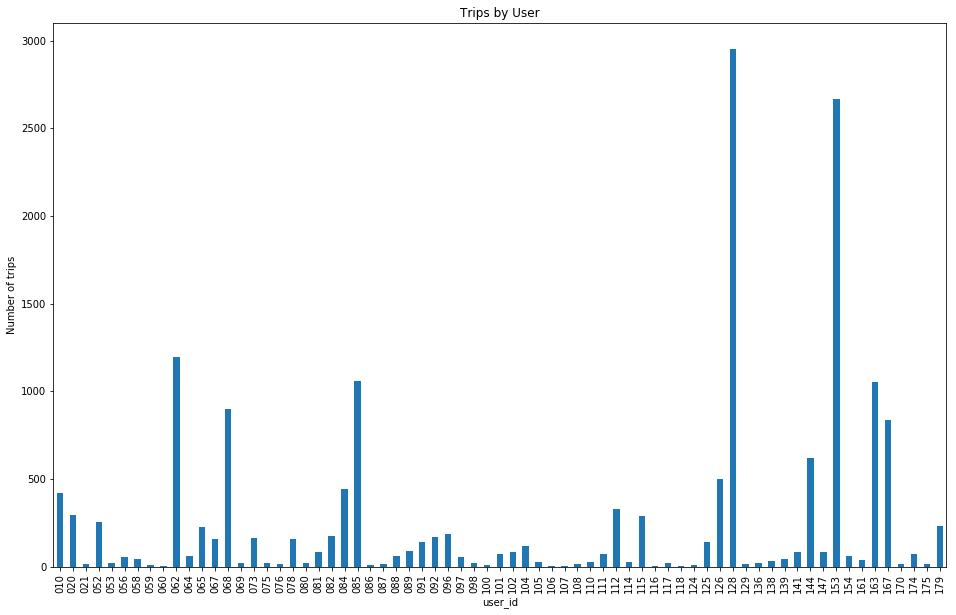

In [12]:
if SHOW_PLOTS:
    trips_by_user = plot_trips_by_user(data)

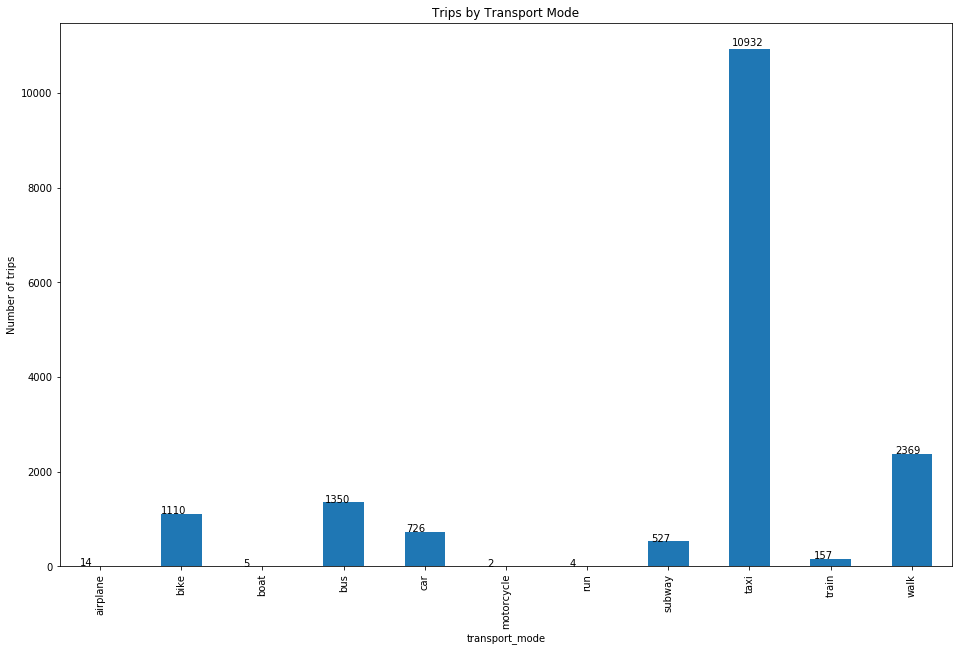

In [13]:
if SHOW_PLOTS:
    trips_by_transport = plot_trips_by_transport(data)

## Select car trajectories

In [14]:
select_transport_mode = "car"
data = data[data.transport_mode == select_transport_mode]

In [15]:
print("No. of {} trajectories: {}".format(select_transport_mode, data.trip_id.nunique()))

No. of car trajectories: 726


In [16]:
data.to_csv("./geolife_car_trips.csv")